In [1]:
import re
import math
import pickle
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from time import time
import IPython.display as Disp
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from underthesea import word_tokenize
from operator import itemgetter
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('2k_data_Sep.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Feedback ID      2000 non-null   float64
 1   Lookup Text      2000 non-null   object 
 2   Question Text    2000 non-null   object 
 3   Feedback Type    2000 non-null   object 
 4   Feedback Result  2000 non-null   object 
 5   Human Feedback   2000 non-null   object 
 6   Lookup Image     2000 non-null   object 
 7   Question Image   2000 non-null   object 
dtypes: float64(1), object(7)
memory usage: 125.1+ KB


In [3]:
def clean_function(text):  
    #lowercase
    text = text.lower()
    
#     #xoá ký tự đặc biệt, ký tự không phải alphanumeric 
#     text = re.sub("[^a-z0-9àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễòóọỏõôồốộổỗơờớợởỡìíịỉĩùúụủũưừứựửữỳýỵỷỹđ]",' ', text)
    text = re.sub("[\àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễòóọỏõôồốộổỗơờớợởỡìíịỉĩùúụủũưừứựửữỳýỵỷỹđ]",'', text)    
#     #xoá leading zero
#     text = [e.lstrip('0') for e in text.split(' ')]
#     text = (' ').join(text)
    
    #replace extra spaces with single space
    text = re.sub(' +',' ',text)
    
    #xoá khoảng trắng ở đầu và cuối mỗi câu
    text = text.strip()
    
    #word tokenzie
    text = word_tokenize(text, format='text')
    return text

In [4]:
df['index_org'] = df.index

df['clean_lookup'] = df['Lookup Text'].map(lambda x: clean_function(x))
df['clean_question'] = df['Question Text'].map(lambda x: clean_function(x))

df['char_count_lookup'] = df['clean_lookup'].str.len()
df['word_count_lookup'] = df['clean_lookup'].str.split().str.len()
df['average_word_length_lookup'] = df['char_count_lookup'] / df['word_count_lookup']

df['char_count_question'] = df['clean_question'].str.len()
df['word_count_question'] = df['clean_question'].str.split().str.len()
df['average_word_length_question'] = df['char_count_question'] / df['word_count_question']

In [5]:
check_dup = df[['Lookup Text', 'Question Text']][df[['Lookup Text', 'Question Text']].duplicated()]
df = df.drop(check_dup.index)
df = df.reset_index(drop = True)
df.shape

(1962, 17)

In [6]:
human_fb = pd.DataFrame(df.groupby('Human Feedback')['Feedback ID'].count()).reset_index()
human_fb

,Human Feedback,Feedback ID
0,MATCH,996
1,NOT MATCH,966


In [7]:
mask1 = df['Human Feedback'] == 'NOT MATCH'
mask2 = df['Human Feedback'] == 'MATCH'

df_neg = df[mask1].reset_index(drop = True)
df_pos = df[mask2].reset_index(drop = True)

print(df_neg.shape)
print(df_pos.shape)

(966, 17)
(996, 17)


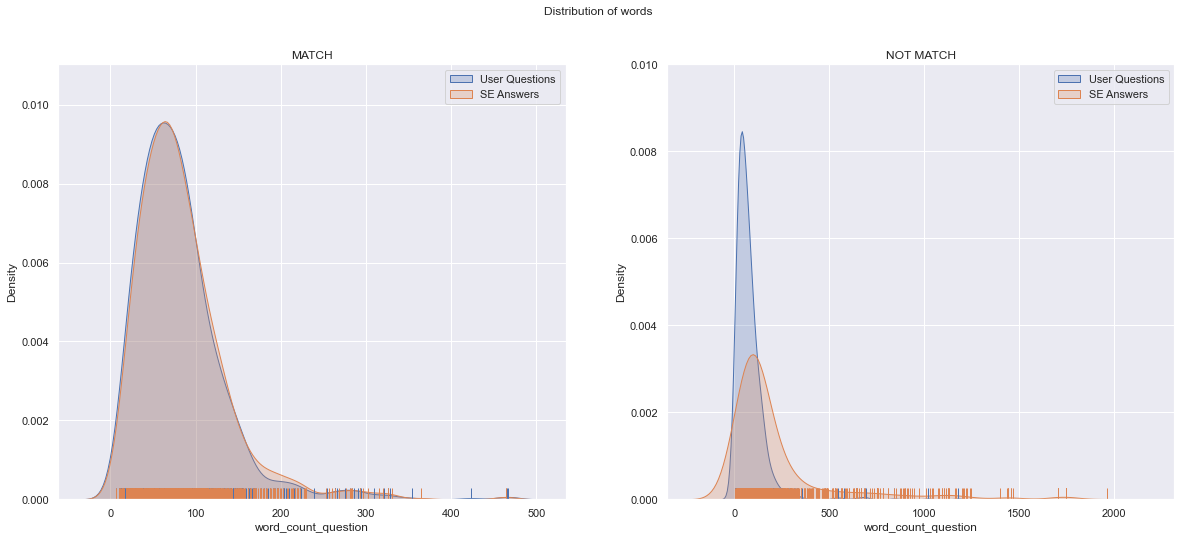

In [8]:
sb.set_theme()
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.distplot(df_pos['word_count_lookup'], hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label='User Questions')
sb.distplot(df_pos['word_count_question'],hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label='SE Answers')
plt.title('MATCH')
plt.legend()
plt.subplot(122)
sb.distplot(df_neg['word_count_lookup'], hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label='User Questions')
sb.distplot(df_neg['word_count_question'],hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label='SE Answers')
plt.ylim([0, 0.01])
plt.title('NOT MATCH')
plt.legend()
plt.suptitle('Distribution of words');

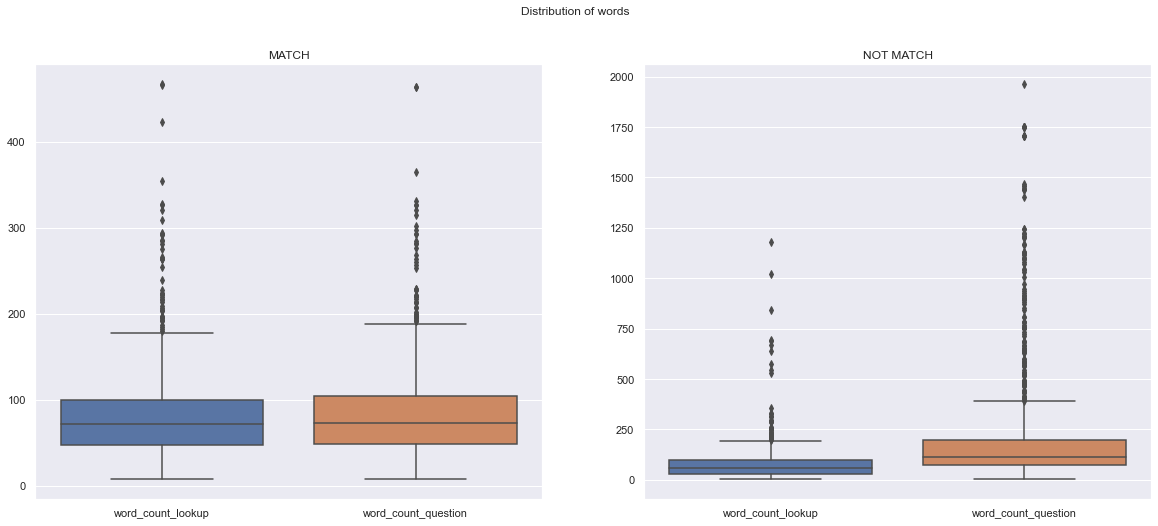

In [9]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.boxplot(data = df_pos[['word_count_lookup', 'word_count_question']])
plt.title('MATCH')
plt.subplot(122)
sb.boxplot(data = df_neg[['word_count_lookup', 'word_count_question']])
plt.title('NOT MATCH')
plt.suptitle('Distribution of words');

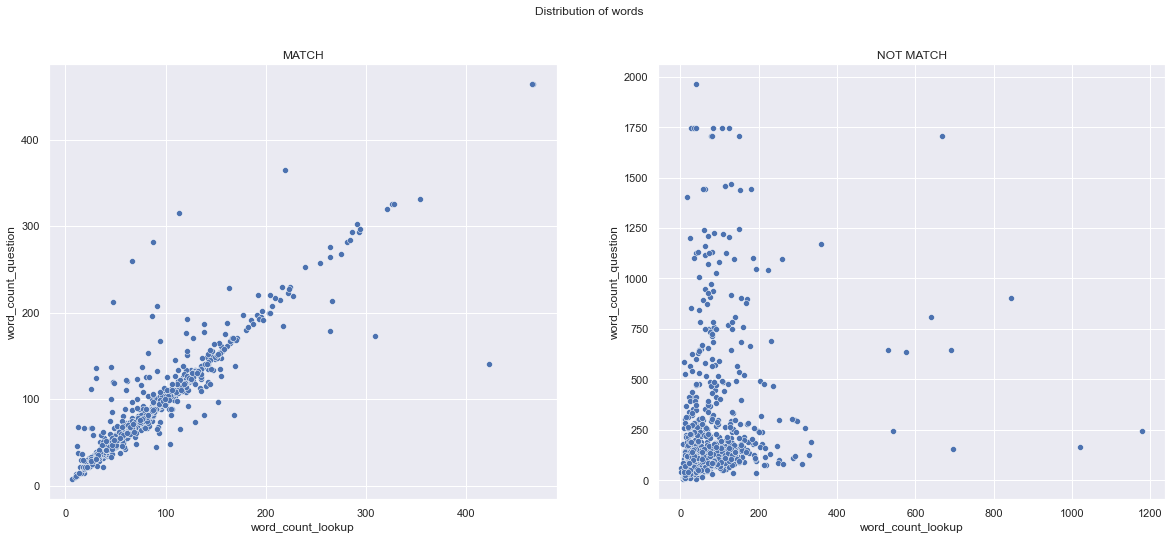

In [10]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.scatterplot(data = df_pos, x = df_pos['word_count_lookup'], y = df_pos['word_count_question'])
plt.title('MATCH')
plt.subplot(122)
sb.scatterplot(data = df_neg, x = df_neg['word_count_lookup'], y = df_neg['word_count_question'])
plt.title('NOT MATCH')
plt.suptitle('Distribution of words');

In [11]:
df_neg['diff_word'] = abs(df_neg['word_count_question'] - df_neg['word_count_lookup'])
df_pos['diff_word'] = abs(df_pos['word_count_question'] - df_pos['word_count_lookup'])

my_bins = [-np.inf, 5, 10, 15, 20, np.inf]
my_labels = ['Very low', 'Low', 'Medium', 'High', 'Very high']

df_neg['diff_bin'] = pd.cut(df_neg['diff_word'], bins=my_bins, labels=my_labels)
df_pos['diff_bin'] = pd.cut(df_pos['diff_word'], bins=my_bins, labels=my_labels)

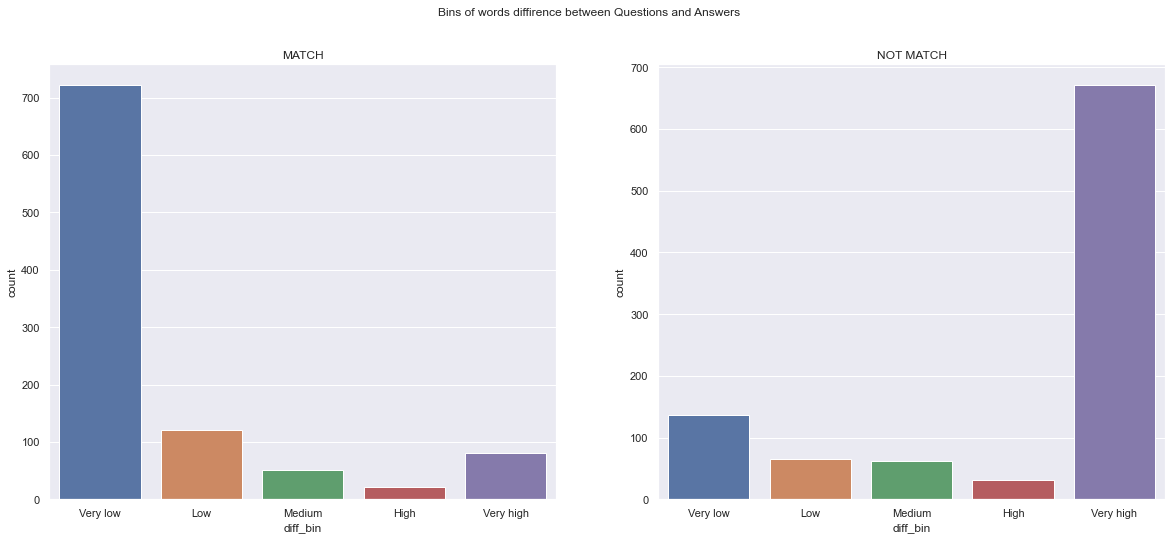

In [12]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.countplot(df_pos['diff_bin'])
plt.title('MATCH')
plt.subplot(122)
sb.countplot(df_neg['diff_bin'])
plt.title('NOT MATCH')
plt.suptitle('Bins of words diffirence between Questions and Answers');

In [13]:
with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    vn_stop_words = file.read()
vn_stop_words = vn_stop_words.split('\n') 

# combine Vietnamese stopwords and English stopwords
stop_words = ENGLISH_STOP_WORDS.union(vn_stop_words)

# 2. Gensim search in NOT MATCH Dataset

In [14]:
questions_neg = [[text for text in x.split()] for x in df_neg['clean_question']]

questions_neg = [[t for t in text if not t in stop_words] for text in questions_neg]

dict_neg = corpora.Dictionary(questions_neg)

corpus_neg = [dict_neg.doc2bow(quest) for quest in questions_neg]

questions_neg_tfidf_model = models.TfidfModel(corpus_neg, id2word=dict_neg)
questions_neg_lsi_model = models.LsiModel(questions_neg_tfidf_model[corpus_neg], id2word=dict_neg, num_topics=100)

corpora.MmCorpus.serialize('question_neg_tfidf_model_mm', questions_neg_tfidf_model[corpus_neg])
corpora.MmCorpus.serialize('question_neg_lsi_model_mm', questions_neg_lsi_model[questions_neg_tfidf_model[corpus_neg]])

In [15]:
questions_neg_tfidf_corpus = corpora.MmCorpus('question_neg_tfidf_model_mm')
questions_neg_lsi_corpus = corpora.MmCorpus('question_neg_lsi_model_mm')

print(questions_neg_tfidf_corpus)
print(questions_neg_lsi_corpus)

MmCorpus(966 documents, 4589 features, 52956 non-zero entries)
MmCorpus(966 documents, 100 features, 96600 non-zero entries)


In [16]:
questions_neg_index = similarities.MatrixSimilarity(questions_neg_lsi_corpus, 
                                                    num_features = questions_neg_lsi_corpus.num_terms)

In [17]:
def gensim_search(query, data, dictionary, similarities_matrix, 
                  questions_tfidf_model, questions_lsi_model, check_time = True):
    t0 = time()
    q = clean_function(query).split()
    query_bow = dictionary.doc2bow(q)
    query_tfidf = questions_tfidf_model[query_bow]
    query_lsi = questions_lsi_model[query_tfidf]

    similarities_matrix.num_best = 5
    questions_list = similarities_matrix[query_lsi]

    questions_list.sort(key=itemgetter(1), reverse=True)
    questions_text = []

    for j, name in enumerate(questions_list):
        questions_text.append(
            {'lookup_text': query * 5,
             'question_text': data['Question Text'][name[0]],
             'gensim_score': round((name[1] * 100),2),
             'gs_word_count_question': data['word_count_question'][name[0]],
             'gs_diff_bin': data['diff_bin'][name[0]],
             'gensim_image': data['Question Image'][name[0]]})
        if j == (similarities_matrix.num_best-1):
            break
    results = pd.DataFrame(questions_text, columns=['lookup_text', 'question_text','gensim_score', 
                                                    'gs_word_count_question', 'gs_diff_bin', 'gensim_image'])
    if check_time:
        print('Time:', time()-t0)
    return results

In [18]:
def gensim_search_all(queries, data, dictionary, similarities_matrix, 
                      questions_tfidf_model, questions_lsi_model, check_time = True):
    t0 = time()
    df_final = pd.DataFrame(columns = ['lookup_text', 'question_text', 'gensim_score', 
                                       'gs_word_count_question', 'gs_diff_bin', 'gs_image'])
    for query in queries:
        q = clean_function(query).split()
        query_bow = dictionary.doc2bow(q)
        query_tfidf = questions_tfidf_model[query_bow]
        query_lsi = questions_lsi_model[query_tfidf]

        similarities_matrix.num_best = 5
        questions_list = similarities_matrix[query_lsi]

        questions_list.sort(key=itemgetter(1), reverse=True)
        questions_text = []

        for j, name in enumerate(questions_list):
            questions_text.append(
                {'lookup_text': query * 5,
                 'question_text': data['Question Text'][name[0]],
                 'gensim_score': round((name[1] * 100),2),
                 'gs_word_count_question': data['word_count_question'][name[0]],
                 'gs_diff_bin': data['diff_bin'][name[0]],
                 'gs_image': data['Question Image'][name[0]]})
            if j == (similarities_matrix.num_best-1):
                break
        result =  pd.DataFrame(questions_text, columns=['lookup_text', 'question_text','gensim_score', 
                                                        'gs_word_count_question', 'gs_diff_bin', 'gs_image']).head(1)
        df_final = pd.concat([df_final, result])
    if check_time:
        print('Time:', time()-t0)
    return df_final

In [19]:
gensim_search(df_neg.iloc[0]['Lookup Text'], df_neg, 
              dictionary=dict_neg, 
              similarities_matrix=questions_neg_index,
              questions_tfidf_model=questions_neg_tfidf_model, 
              questions_lsi_model=questions_neg_lsi_model)

Time: 0.010866165161132812


,lookup_text,question_text,gensim_score,gs_word_count_question,gs_diff_bin,gensim_image
0,b) \( \left(\frac{-4}{15}-\frac{18}{19}\right)...,a) \( \frac{2}{3}+\frac{-1}{3}+\frac{7}{15} \)...,91.45,217,Very high,https://s3.icankid.io/uploads/question/41bf56d...
1,b) \( \left(\frac{-4}{15}-\frac{18}{19}\right)...,1. Tinh:\na) \( \frac{2}{15}+\left(\frac{-5}{2...,87.46,464,Very high,https://s3.icankid.io/uploads/question/97249ea...
2,b) \( \left(\frac{-4}{15}-\frac{18}{19}\right)...,4. Tính:\na) \( \frac{3}{7} \cdot\left(-\frac{...,82.84,297,Very high,https://s3.icankid.io/uploads/question/ed6be8e...
3,b) \( \left(\frac{-4}{15}-\frac{18}{19}\right)...,Bai 1: Ginh nhanh (neis w' the')\na) \( \frac{...,82.49,205,Very high,https://s3.icankid.io/uploads/question/4763716...
4,b) \( \left(\frac{-4}{15}-\frac{18}{19}\right)...,Bài 1. Tính nhanh:\na) \( \frac{-3}{7}+\frac{1...,81.52,684,Very high,https://s3.icankid.io/uploads/question/b978f76...


In [20]:
results_neg = gensim_search_all(df_neg['Lookup Text'], df_neg,
                               dictionary=dict_neg, 
                               similarities_matrix=questions_neg_index,
                               questions_tfidf_model=questions_neg_tfidf_model, 
                               questions_lsi_model=questions_neg_lsi_model)

Time: 7.7191150188446045


In [21]:
results_neg.reset_index(drop = True, inplace = True)

df_neg['search_result'] = results_neg['question_text']
df_neg['gensim_score'] = results_neg['gensim_score']
df_neg['gs_word_count_question'] = results_neg['gs_word_count_question']
df_neg['gs_diff_bin'] = results_neg['gs_diff_bin']
df_neg['gs_image'] = results_neg['gs_image']

In [22]:
mask3 = df_neg['Lookup Text'] != df_neg['search_result']

df_check_neg = df_neg[mask3]
df_check_neg.shape

(947, 24)

In [23]:
mask3 = df_neg['Lookup Text'] != df_neg['search_result']

df_check_neg = df_neg[mask3]
df_check_neg.shape

(947, 24)

In [24]:
def check_wrong_results_neg(indices):
    index_ = df_check_neg.index.tolist()
    no_results = []
    top5_results = []
    for num in indices:
        df_results = gensim_search(df_check_neg.iloc[num]['Lookup Text'], df_neg,
                                   dictionary=dict_neg, 
                                   similarities_matrix=questions_neg_index,
                                   questions_tfidf_model=questions_neg_tfidf_model, 
                                   questions_lsi_model=questions_neg_lsi_model, check_time = False)
        top_results = df_results['question_text'].values
        if (df_check_neg.iloc[num]['Lookup Text'] in top_results):
            top5_results.append(index_[num])
        else:
            no_results.append(index_[num])
    return top5_results, no_results

In [25]:
top5_result_neg, no_result_neg = check_wrong_results_neg(list(range(0, len(df_check_neg.index))))

print(len(top5_result_neg))
print(len(no_result_neg))

0
947


In [26]:
mask4 = df_neg['Lookup Text'] == df_neg['search_result']

df_match_neg = df_neg[mask4]
df_match_neg.shape

(19, 24)

In [27]:
mask3_1 = df_neg['Question Text'] != df_neg['search_result']

df_check_demo = df_neg[mask3_1]
df_check_demo.shape

(480, 24)

In [28]:
mask4_1 = df_neg['Question Text'] == df_neg['search_result']

df_demo = df_neg[mask4_1]
df_demo.shape

(486, 24)

In [29]:
def check_wrong_demo(indices):
    index_ = df_check_neg.index.tolist()
    no_results = []
    top5_results = []
    for num in indices:
        df_results = gensim_search(df_check_neg.iloc[num]['Lookup Text'], df_neg,
                                   dictionary=dict_neg, 
                                   similarities_matrix=questions_neg_index,
                                   questions_tfidf_model=questions_neg_tfidf_model, 
                                   questions_lsi_model=questions_neg_lsi_model, check_time = False)
        top_results = df_results['question_text'].values
        if (df_check_neg.iloc[num]['Lookup Text'] in top_results) or (df_check_neg.iloc[num]['Question Text'] in top_results):
            top5_results.append(index_[num])
        else:
            no_results.append(index_[num])
    return top5_results, no_results

top5_demo, no_demo = check_wrong_demo(list(range(0, len(df_check_demo.index))))

print(len(top5_demo))
print(len(no_demo))

326
154


In [30]:
df_top5_demo = df_neg.iloc[top5_demo, :]
df_top5_demo.shape

(326, 24)

In [31]:
df_no_demo = df_neg.iloc[no_demo, :]
df_no_demo.shape

(154, 24)

In [32]:
df_top5_neg = df_neg.iloc[top5_result_neg, :]
df_top5_neg.shape

(0, 24)

In [33]:
df_no_neg = df_neg.iloc[no_result_neg, :]
df_no_neg.shape

(947, 24)

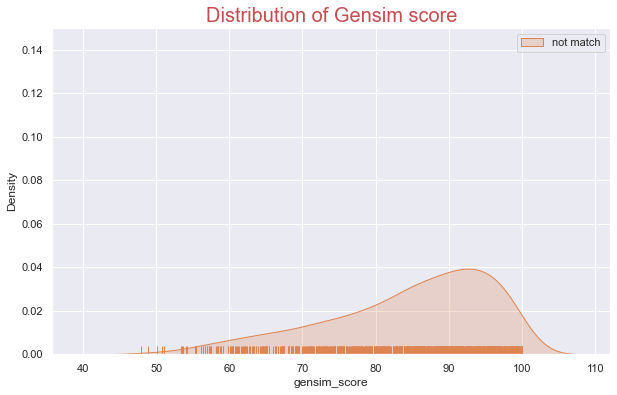

In [34]:
plt.figure(figsize=(10,6))
sb.distplot(df_match_neg.gensim_score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'matching')
# sb.distplot(df_top5_neg.jc_score, label = 'top5_relevance')
sb.distplot(df_no_neg.gensim_score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "not match")
# plt.xlim([0, 1.5])
plt.ylim([0, 0.15])
plt.legend()
plt.title('Distribution of Gensim score', fontsize = 20, color = 'r');

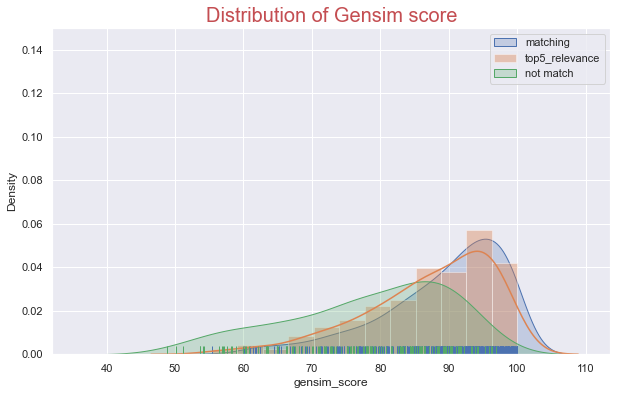

In [35]:
plt.figure(figsize=(10,6))
sb.distplot(df_demo.gensim_score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'matching')
sb.distplot(df_top5_demo.gensim_score, label = 'top5_relevance')
sb.distplot(df_no_demo.gensim_score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "not match")
# plt.xlim([0, 1.5])
plt.ylim([0, 0.15])
plt.legend()
plt.title('Distribution of Gensim score', fontsize = 20, color = 'r');

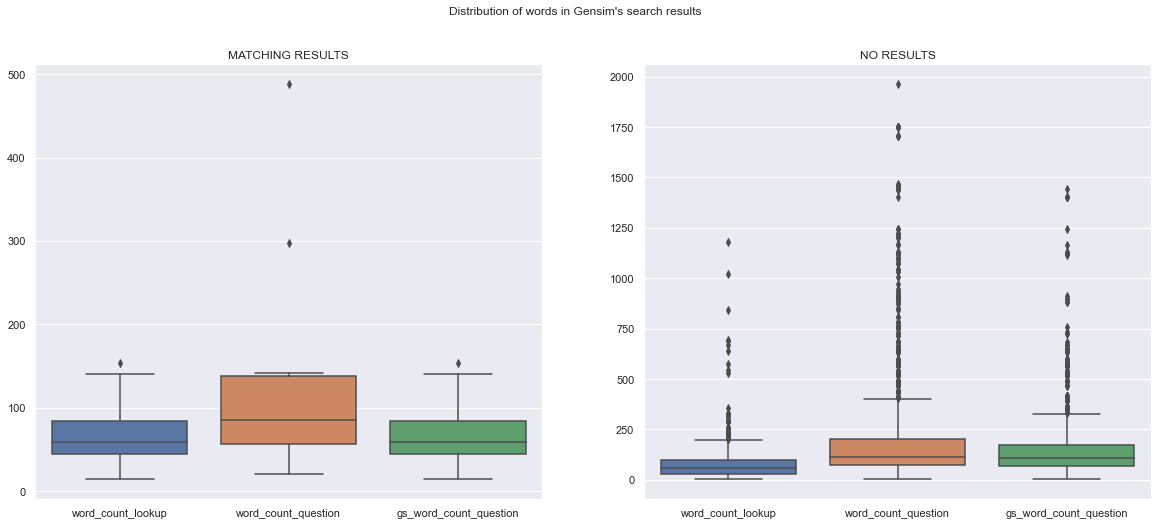

In [36]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.boxplot(data = df_match_neg[['word_count_lookup', 'word_count_question', 'gs_word_count_question']])
plt.title('MATCHING RESULTS')
plt.subplot(122)
sb.boxplot(data = df_no_neg[['word_count_lookup', 'word_count_question', 'gs_word_count_question']])
plt.title('NO RESULTS')
plt.suptitle("Distribution of words in Gensim's search results");

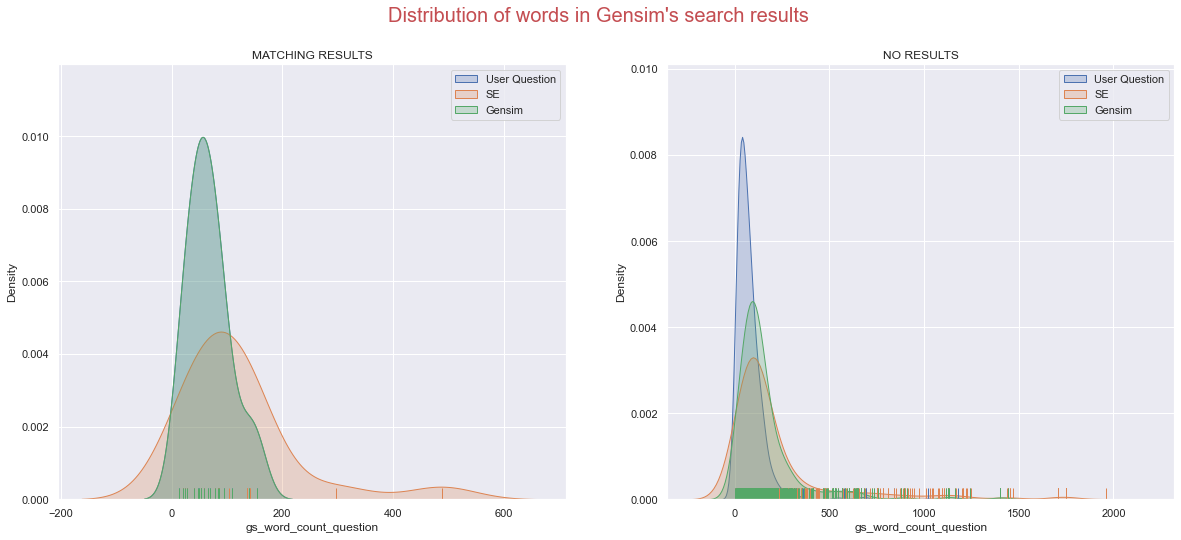

In [37]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.distplot(df_match_neg.word_count_lookup, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = "User Question")
sb.distplot(df_match_neg.word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = "SE")
sb.distplot(df_match_neg.gs_word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = "Gensim")
plt.legend()
plt.title('MATCHING RESULTS')
plt.subplot(122)
sb.distplot(df_no_neg.word_count_lookup, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "User Question")
sb.distplot(df_no_neg.word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "SE")
sb.distplot(df_no_neg.gs_word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "Gensim")
plt.legend()
plt.title('NO RESULTS')
plt.suptitle("Distribution of words in Gensim's search results", fontsize = 20, color = 'r')
plt.show()

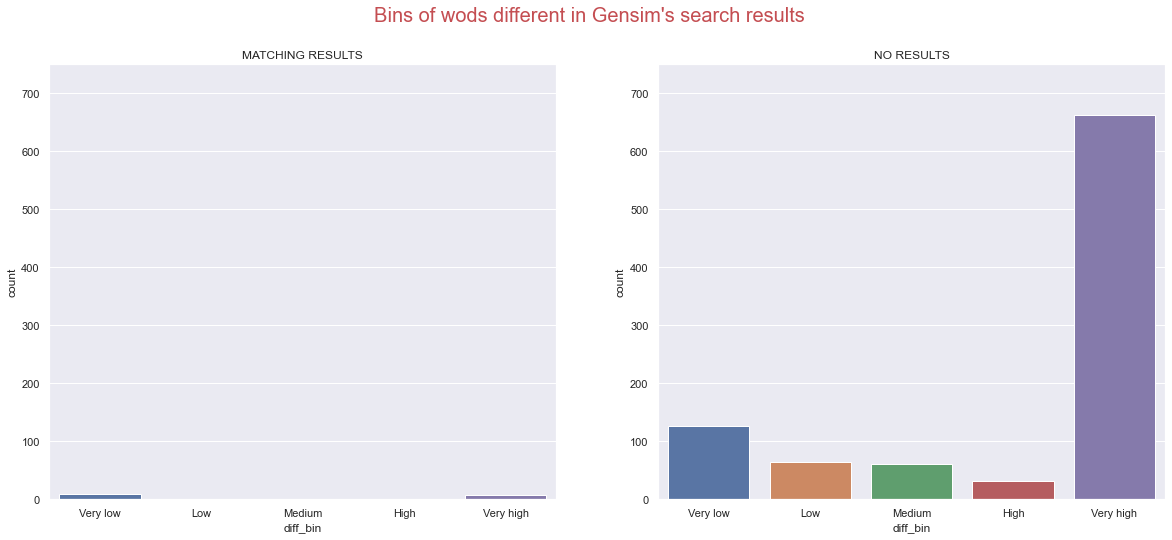

In [38]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.countplot(df_match_neg['diff_bin'])
plt.ylim([0, 750])
plt.title('MATCHING RESULTS')
plt.subplot(122)
sb.countplot(df_no_neg['diff_bin'])
plt.ylim([0, 750])
plt.title('NO RESULTS')
plt.suptitle("Bins of wods different in Gensim's search results", fontsize = 20, color = 'r');

# 3. Gensim search in MATCH Dataset

In [39]:
questions_pos = [[text for text in x.split()] for x in df_pos['clean_question']]

questions_pos = [[t for t in text if not t in stop_words] for text in questions_pos]

dict_pos = corpora.Dictionary(questions_pos)

corpus_pos = [dict_pos.doc2bow(quest) for quest in questions_pos]

questions_pos_tfidf_model = models.TfidfModel(corpus_pos, id2word=dict_pos)
questions_pos_lsi_model = models.LsiModel(questions_pos_tfidf_model[corpus_pos], id2word=dict_pos, num_topics=500)

corpora.MmCorpus.serialize('question_pos_tfidf_model_mm', questions_pos_tfidf_model[corpus_pos])
corpora.MmCorpus.serialize('question_pos_lsi_model_mm', questions_pos_lsi_model[questions_pos_tfidf_model[corpus_pos]])

In [40]:
from pprint import pprint
pprint(questions_pos_lsi_model.print_topics(-1))

[(0,
  '-0.327*"x" + -0.301*"{" + -0.243*"frac" + -0.239*"}" + -0.213*"sqrt" + '
  '-0.207*"^" + -0.205*"-" + -0.179*"2" + -0.174*"+" + -0.158*"._\\"'),
 (1,
  '-0.284*"sqrt" + -0.213*"{" + -0.208*"frac" + 0.202*"s" + 0.188*"m" + '
  '-0.165*"}" + 0.150*"t" + 0.145*"," + 0.140*"hnh" + 0.139*"n"'),
 (2,
  '-0.563*"sqrt" + 0.469*"x" + 0.212*"^" + 0.153*"+" + -0.143*"frac" + '
  '-0.127*"{" + -0.115*"hnh" + 0.113*"^_{" + 0.112*"2" + -0.106*"}_+_\\"'),
 (3,
  '-0.567*"sqrt" + 0.408*"frac" + -0.309*"x" + 0.235*"}_{" + '
  '0.202*"}_\\_right" + 0.152*"\\_left" + 0.142*"{" + 0.134*"}" + 0.133*"7" + '
  '-0.121*"^"'),
 (4,
  '-0.504*"&" + -0.282*";" + -0.195*"sqrt" + 0.194*"^_{_\\" + 0.184*"sin" + '
  '0.178*"circ" + -0.166*"tp" + 0.153*"pi" + 0.150*"cos" + -0.149*"|"'),
 (5,
  '0.647*"&" + -0.339*";" + 0.190*"|" + -0.177*"tp" + -0.165*"\\_}_\\" + '
  '-0.143*"hp" + 0.142*"^" + 0.138*"hline" + 0.133*"^_{_\\" + 0.130*"circ"'),
 (6,
  '-0.361*"._\\" + 0.307*"^" + -0.264*"&" + -0.250*"m" + -0.225

In [41]:
questions_pos_tfidf_corpus = corpora.MmCorpus('question_pos_tfidf_model_mm')
questions_pos_lsi_corpus = corpora.MmCorpus('question_pos_lsi_model_mm')

print(questions_pos_tfidf_corpus)
print(questions_pos_lsi_corpus)

MmCorpus(996 documents, 2730 features, 35089 non-zero entries)
MmCorpus(996 documents, 500 features, 498000 non-zero entries)


In [42]:
questions_pos_index = similarities.MatrixSimilarity(questions_pos_lsi_corpus, 
                                                    num_features = questions_pos_lsi_corpus.num_terms)

In [43]:
gensim_search(df_pos.iloc[0]['Lookup Text'], df_pos, 
              dictionary=dict_pos, 
              similarities_matrix=questions_pos_index,
              questions_tfidf_model=questions_pos_tfidf_model, 
              questions_lsi_model=questions_pos_lsi_model)

Time: 0.0181729793548584


,lookup_text,question_text,gensim_score,gs_word_count_question,gs_diff_bin,gensim_image
0,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,94.05,131,Very low,https://s3.icankid.io/uploads/question/5a47b89...
1,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,71. Rút gọn các biểu thức sau :\na) \( (\sqrt{...,70.94,191,Low,https://s3.stag.icankids.com.vn/uploads/questi...
2,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,68.74,80,Low,https://s3.icankid.io/uploads/question/2d3358a...
3,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,Bài 9: Tính\na) \( (\sqrt{5})^{2} \)\nb) \( (\...,67.58,72,Very low,https://s3.icankid.io/uploads/question/413b905...
4,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,(4) True cain theie 'o'mẫ.\na) \( \frac{2-\sqr...,66.97,257,Very low,https://s3.icankid.io/uploads/question/0785b09...


In [44]:
results_pos = gensim_search_all(df_pos['Lookup Text'], df_pos,
                               dictionary=dict_pos, 
                               similarities_matrix=questions_pos_index,
                               questions_tfidf_model=questions_pos_tfidf_model, 
                               questions_lsi_model=questions_pos_lsi_model)

Time: 8.365365028381348


In [45]:
results_pos.reset_index(drop = True, inplace = True)

df_pos['search_result'] = results_pos['question_text']
df_pos['gensim_score'] = results_pos['gensim_score']
df_pos['gs_word_count_question'] = results_pos['gs_word_count_question']
df_pos['gs_diff_bin'] = results_pos['gs_diff_bin']
df_pos['gs_image'] = results_pos['gs_image']

In [46]:
mask6 = df_pos['Question Text'] != df_pos['search_result']

df_check_pos = df_pos[mask6]
df_check_pos.shape

(48, 24)

In [47]:
def check_wrong_results_pos(indices):
    index_ = df_check_pos.index.tolist()
    no_results = []
    top5_results = []
    for num in indices:
        df_results = gensim_search(df_check_pos.iloc[num]['Lookup Text'], df_pos,
                                   dictionary=dict_pos, 
                                   similarities_matrix=questions_pos_index,
                                   questions_tfidf_model=questions_pos_tfidf_model, 
                                   questions_lsi_model=questions_pos_lsi_model, check_time = False)
        top_results = df_results['question_text'].values
        if (df_check_pos.iloc[num]['Lookup Text'] in top_results) or (df_check_pos.iloc[num]['Question Text'] in top_results):
            top5_results.append(index_[num])
        else:
            no_results.append(index_[num])
    return top5_results, no_results

In [48]:
top5_result_pos, no_result_pos = check_wrong_results_pos(list(range(0, len(df_check_pos.index))))

print(len(top5_result_pos))
print(len(no_result_pos))

43
5


In [49]:
mask7 = df_pos['Question Text'] == df_pos['search_result']

df_match_pos = df_pos[mask7]
df_match_pos.shape

(948, 24)

In [50]:
df_top5_pos = df_pos.iloc[top5_result_pos, :]
df_top5_pos.shape

(43, 24)

In [51]:
df_no_pos = df_pos.iloc[no_result_pos, :]
df_no_pos.shape

(5, 24)

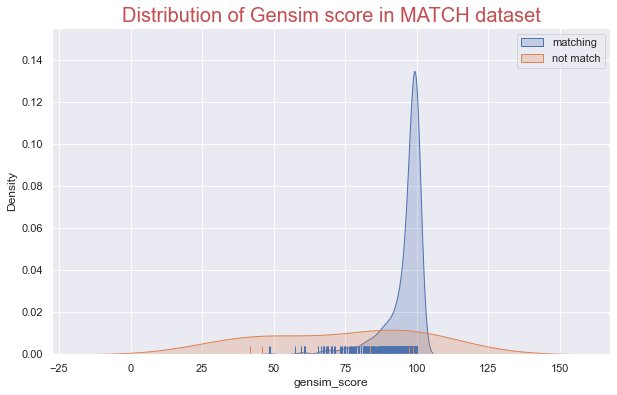

In [52]:
plt.figure(figsize=(10,6))
sb.distplot(df_match_pos.gensim_score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'matching')
# sb.distplot(df_top5_neg.jc_score, label = 'top5_relevance')
sb.distplot(df_no_pos.gensim_score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "not match")
# plt.xlim([0, 1.5])
# plt.ylim([0, 12])
plt.legend()
plt.title('Distribution of Gensim score in MATCH dataset', fontsize = 20, color = 'r');

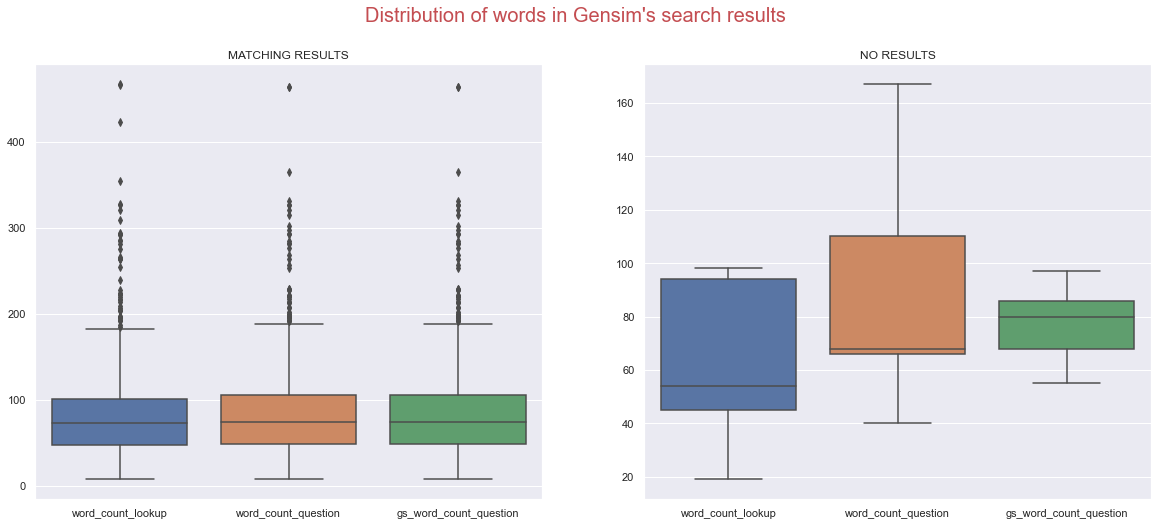

In [53]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.boxplot(data = df_match_pos[['word_count_lookup', 'word_count_question', 'gs_word_count_question']])
plt.title('MATCHING RESULTS')
plt.subplot(122)
sb.boxplot(data = df_no_pos[['word_count_lookup', 'word_count_question', 'gs_word_count_question']])
plt.title('NO RESULTS')
plt.suptitle("Distribution of words in Gensim's search results", fontsize = 20, color = 'r');

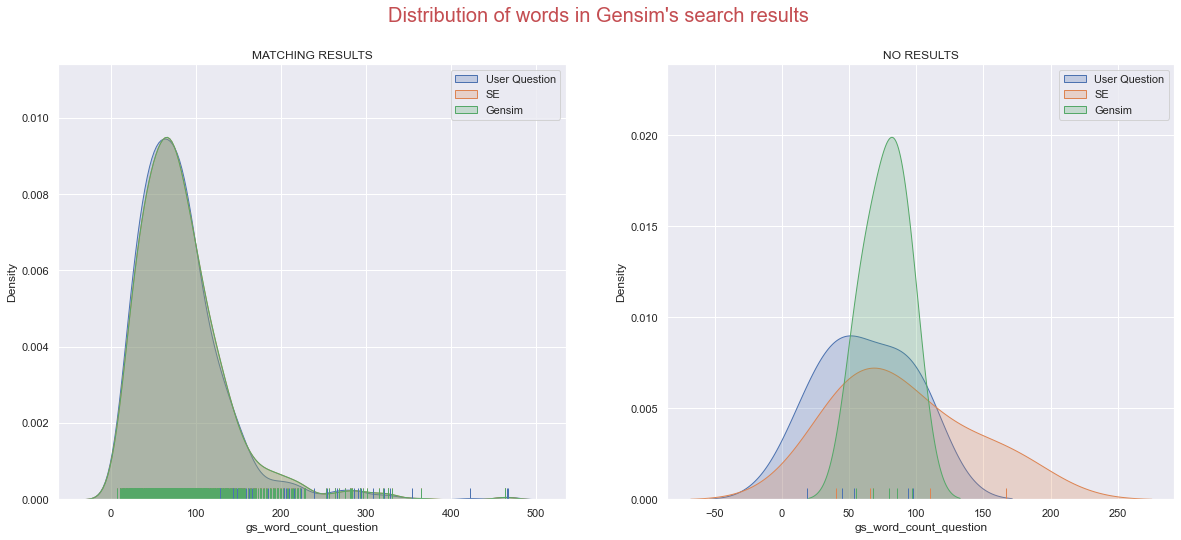

In [54]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.distplot(df_match_pos.word_count_lookup, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = "User Question")
sb.distplot(df_match_pos.word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = "SE")
sb.distplot(df_match_pos.gs_word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = "Gensim")
plt.legend()
plt.title('MATCHING RESULTS')
plt.subplot(122)
sb.distplot(df_no_pos.word_count_lookup, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "User Question")
sb.distplot(df_no_pos.word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "SE")
sb.distplot(df_no_pos.gs_word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "Gensim")
plt.legend()
plt.title('NO RESULTS')
plt.suptitle("Distribution of words in Gensim's search results", fontsize = 20, color = 'r')
plt.show()

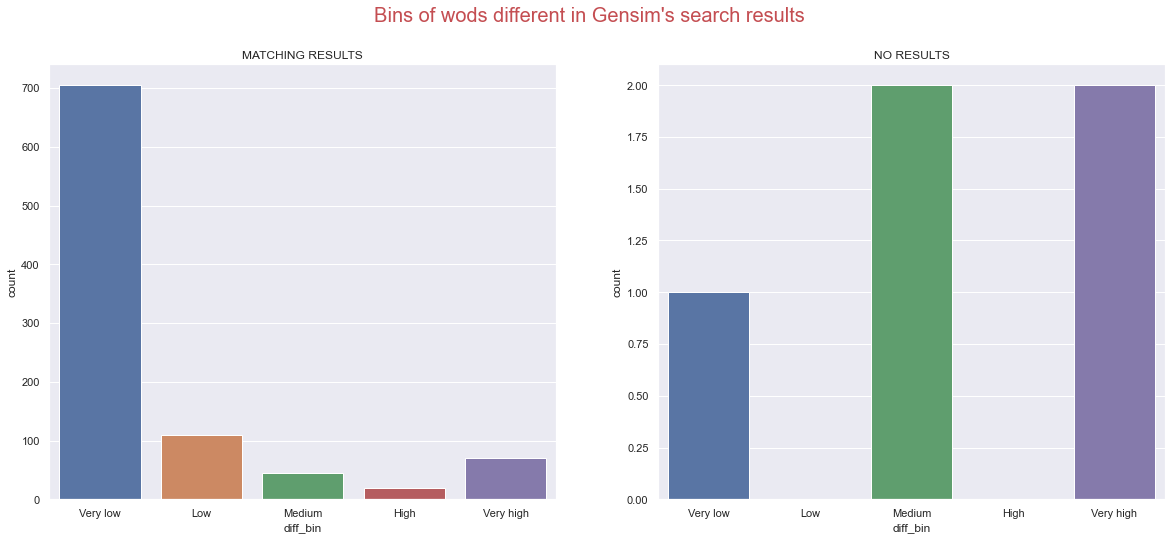

In [55]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.countplot(df_match_pos['diff_bin'])
# plt.ylim([0, 750])
plt.title('MATCHING RESULTS')
plt.subplot(122)
sb.countplot(df_no_pos['diff_bin'])
# plt.ylim([0, 750])
plt.title('NO RESULTS')
plt.suptitle("Bins of wods different in Gensim's search results", fontsize = 20, color = 'r');

# 4. Comparing

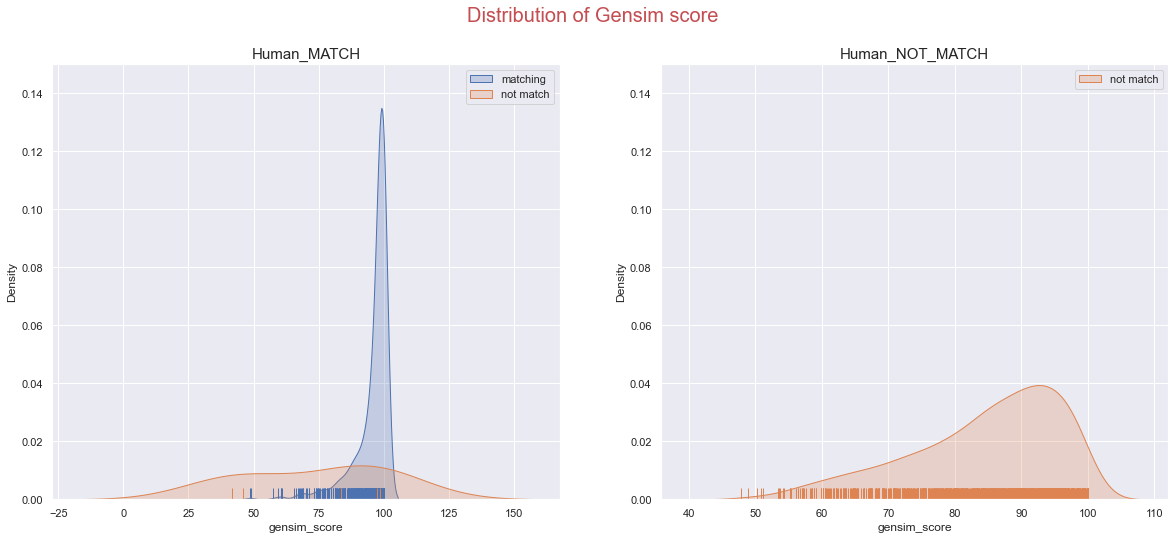

In [56]:
plt.figure(figsize=(20,8))
plt.subplot(121)
sb.distplot(df_match_pos.gensim_score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'matching')
# sb.distplot(df_top5_neg.jc_score, label = 'top5_relevance')
sb.distplot(df_no_pos.gensim_score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "not match")
plt.ylim([0, 0.15])
plt.legend()
plt.title('Human_MATCH', fontsize = 15)
plt.subplot(122)
sb.distplot(df_match_neg.gensim_score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'matching')
# sb.distplot(df_top5_neg.jc_score, label = 'top5_relevance')
sb.distplot(df_no_neg.gensim_score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "not match")
plt.ylim([0, 0.15])
plt.legend()
plt.title('Human_NOT_MATCH', fontsize = 15)
plt.suptitle('Distribution of Gensim score', fontsize = 20, color = 'r')
plt.show()

In [57]:
df_final = pd.DataFrame({'Group': ['Human_MATCH', 'Human_NOT_MATCH'],
                         'Matching': [df_match_pos.shape[0], df_match_neg.shape[0]],
                         'In top5': [df_top5_pos.shape[0], df_top5_neg.shape[0]],
                         'No result': [df_no_pos.shape[0], df_no_neg.shape[0]]})
df_final

,Group,Matching,In top5,No result
0,Human_MATCH,948,43,5
1,Human_NOT_MATCH,19,0,947


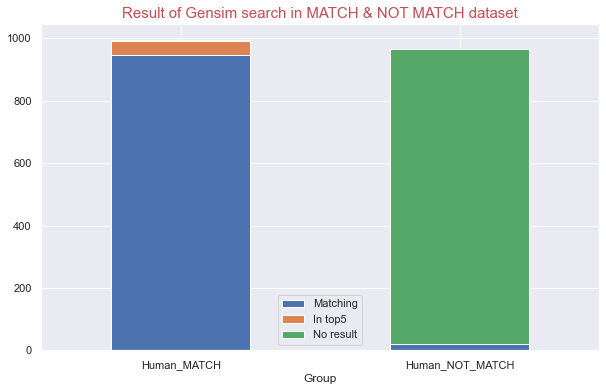

In [58]:
plt.rcParams["figure.figsize"] = [10, 6]
df_final.plot.bar(x = 'Group', stacked = True, rot = 0, width = 0.5)
plt.legend()
plt.title('Result of Gensim search in MATCH & NOT MATCH dataset', fontsize = 15, color = 'r');

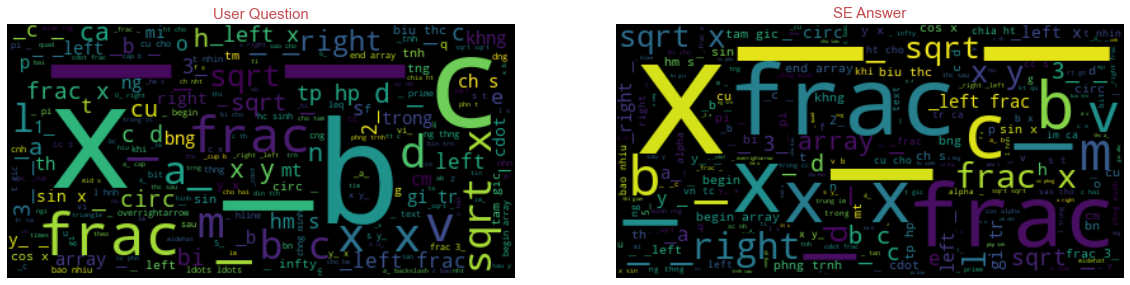

In [59]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
wc= WordCloud(background_color='black')
wc.generate(str(df_neg['clean_lookup'].values))
plt.imshow(wc, interpolation='bilinear')
plt.title('User Question', fontsize = 15, color = 'r')
plt.axis('off')
plt.subplot(122)
wc= WordCloud(background_color='black')
wc.generate(str(df_neg['clean_question'].values))
plt.imshow(wc, interpolation='bilinear')
plt.title('SE Answer', fontsize = 15, color = 'r')
plt.axis('off')
plt.show()

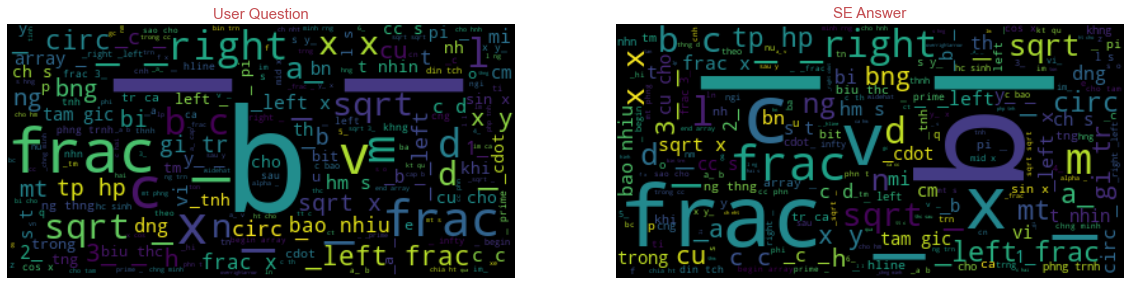

In [60]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
wc= WordCloud(background_color='black')
wc.generate(str(df_pos['clean_lookup'].values))
plt.imshow(wc, interpolation='bilinear')
plt.title('User Question', fontsize = 15, color = 'r')
plt.axis('off')
plt.subplot(122)
wc= WordCloud(background_color='black')
wc.generate(str(df_pos['clean_question'].values))
plt.imshow(wc, interpolation='bilinear')
plt.title('SE Answer', fontsize = 15, color = 'r')
plt.axis('off')
plt.show()

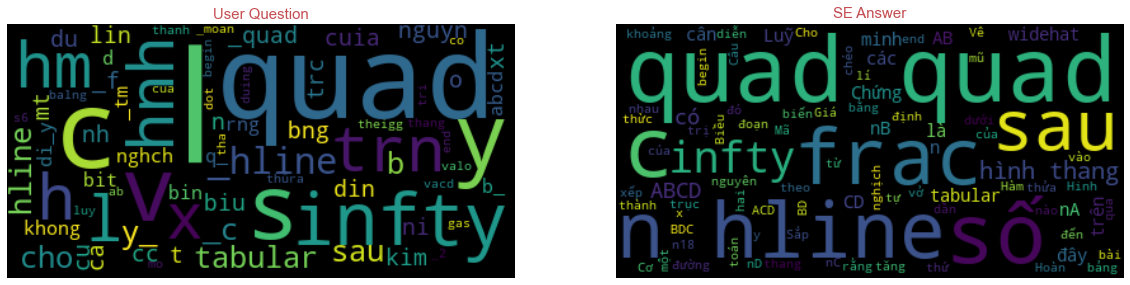

In [61]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
wc= WordCloud(background_color='black')
wc.generate(str(df_no_pos['clean_lookup'].values))
plt.imshow(wc, interpolation='bilinear')
plt.title('User Question', fontsize = 15, color = 'r')
plt.axis('off')
plt.subplot(122)
wc= WordCloud(background_color='black')
wc.generate(str(df_no_pos['search_result'].values))
plt.imshow(wc, interpolation='bilinear')
plt.title('SE Answer', fontsize = 15, color = 'r')
plt.axis('off')
plt.show()

In [62]:
df_no_pos = df_no_pos.sort_values(by = 'gensim_score', ascending = False)

PAIRS: 1 - Gensim score: 98.54
-- Number of words: 98


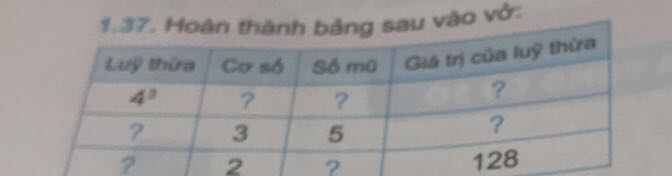

-- Number of words: 110


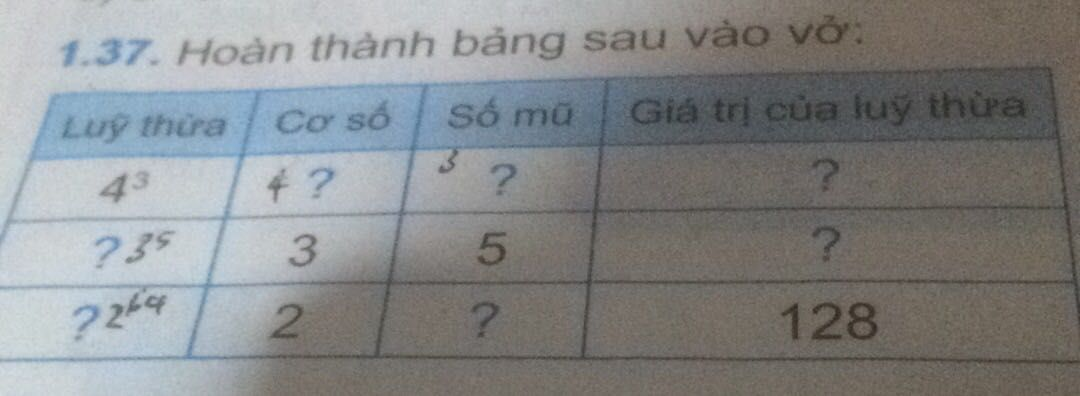

-- Number of words: 97


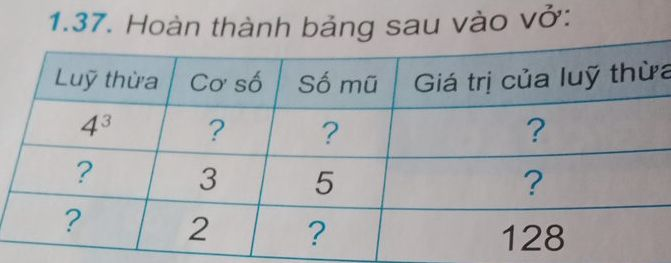

************

PAIRS: 2 - Gensim score: 97.4
-- Number of words: 54


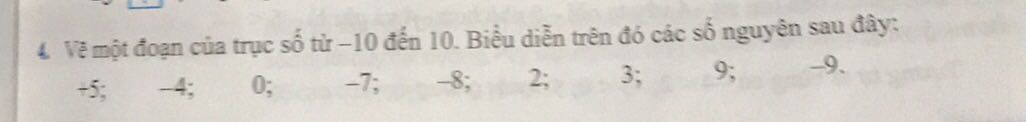

-- Number of words: 68


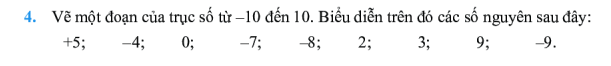

-- Number of words: 55


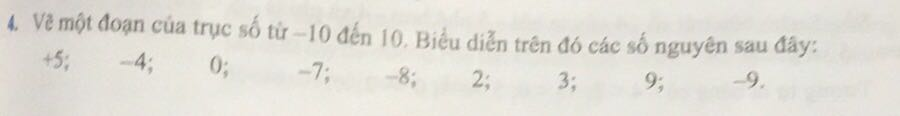

************

PAIRS: 3 - Gensim score: 83.73
-- Number of words: 94


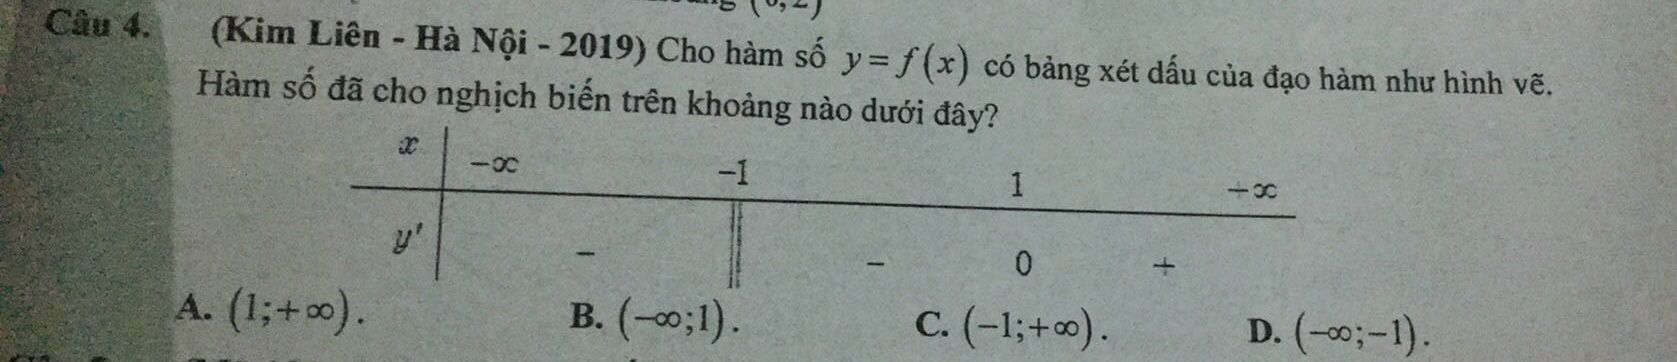

-- Number of words: 167


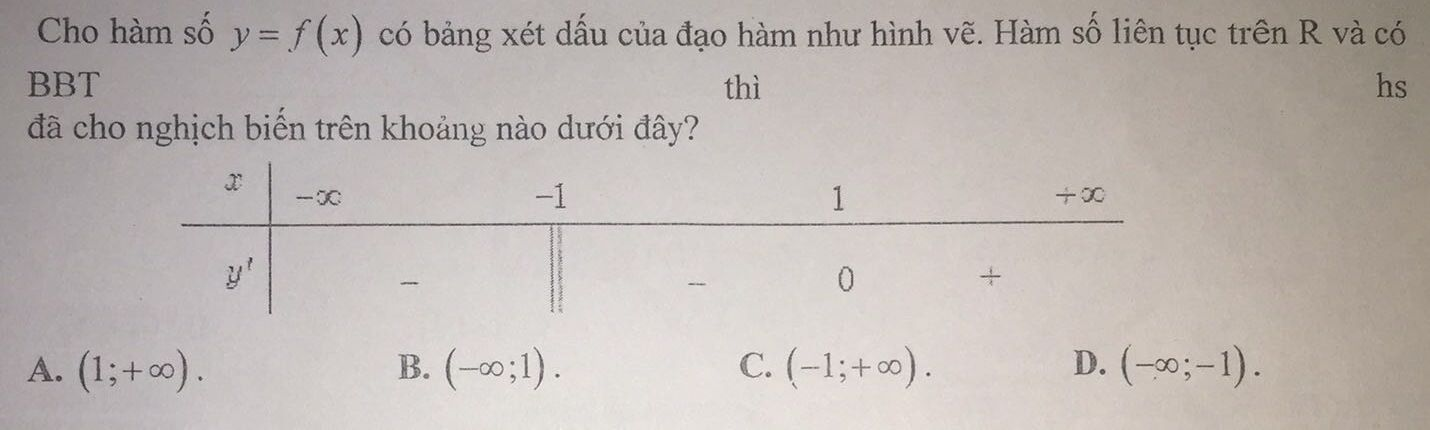

-- Number of words: 80


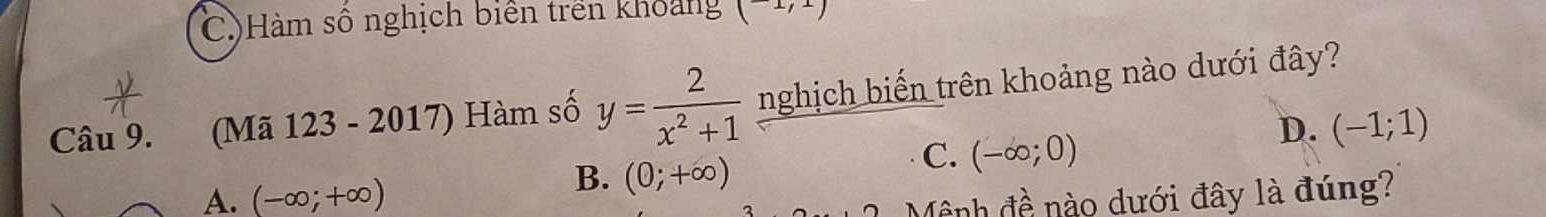

************

PAIRS: 4 - Gensim score: 45.89
-- Number of words: 45


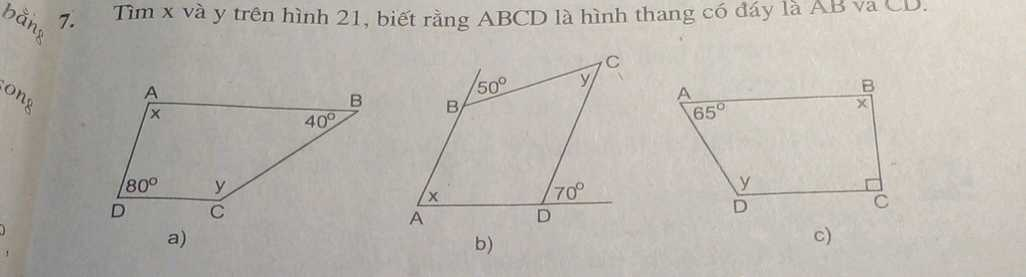

-- Number of words: 40


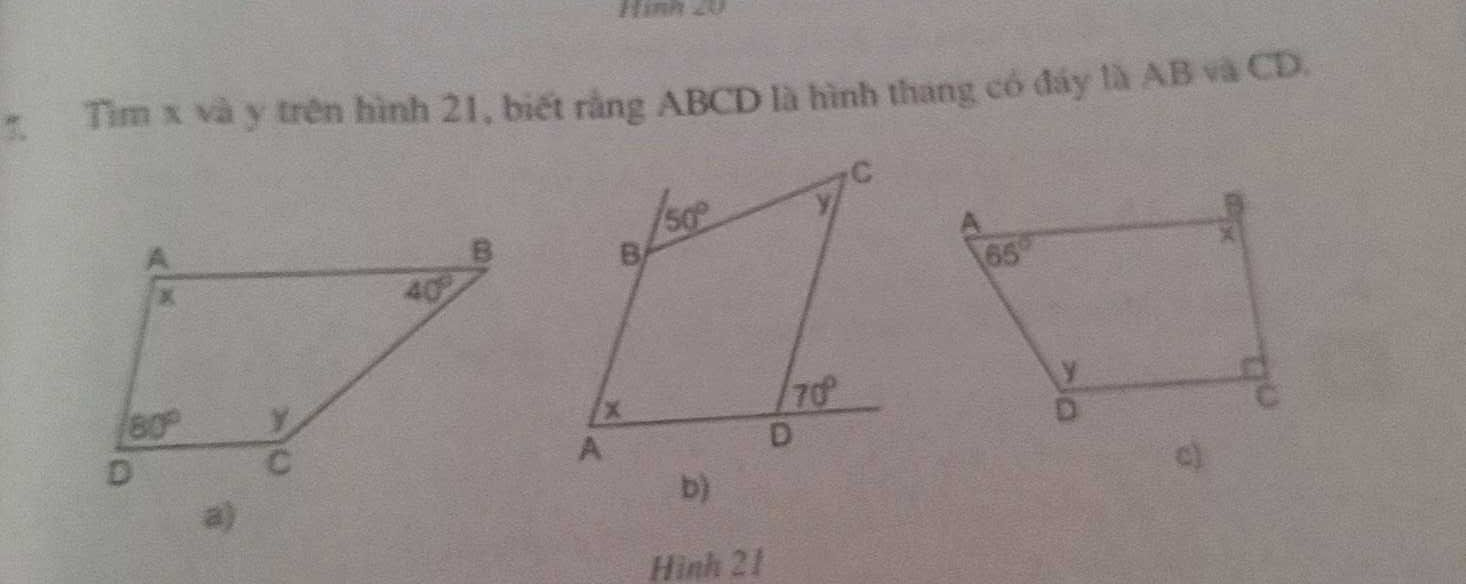

-- Number of words: 86


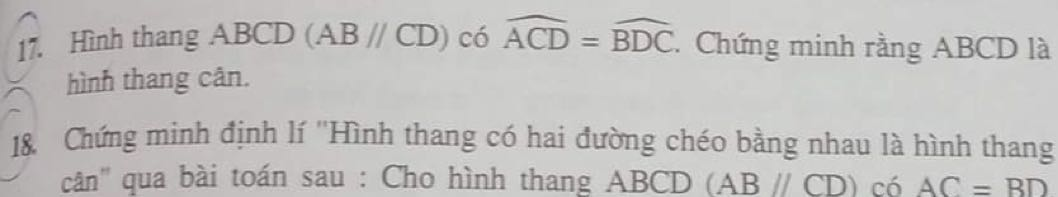

************

PAIRS: 5 - Gensim score: 41.79
-- Number of words: 19


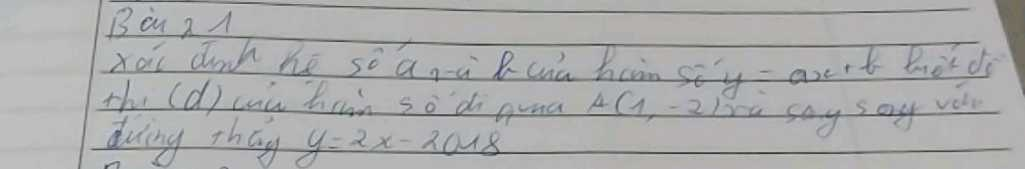

-- Number of words: 66


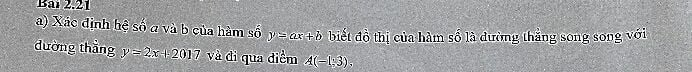

-- Number of words: 68


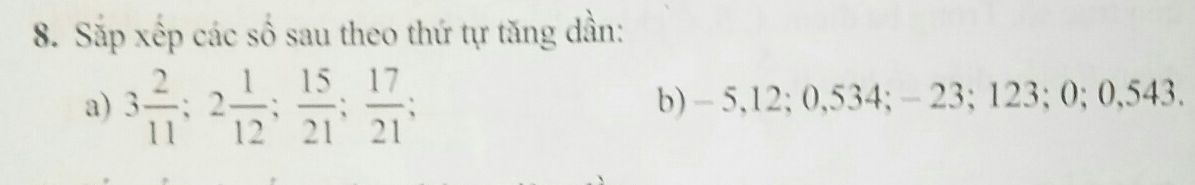

************



In [63]:
idx = 0
for url1, url2 in zip(df_no_pos['Question Image'].values, df_no_pos['gs_image'].values):
    print('PAIRS: {} - Gensim score: {}'.format(idx + 1, df_no_pos['gensim_score'].values[idx]))
    print('-- Number of words:', df_no_pos['word_count_lookup'].values[idx])
    img0 = Disp.Image(requests.get(df_no_pos['Lookup Image'].values[idx]).content)
    display(img0)
    print('-- Number of words:', df_no_pos['word_count_question'].values[idx])
    img1 = Disp.Image(requests.get(url1).content)
    display(img1)
    print('-- Number of words:', df_no_pos['gs_word_count_question'].values[idx])
    img2 = Disp.Image(requests.get(url2).content)
    display(img2)
    print('************')
    print()
    idx += 1